In [1]:
import geopandas as gpd
gdf = gpd.read_file('../data/xenium/stardist_all.geojson')
gdf.crs = None

In [2]:
import geopandas as gpd
from scipy.spatial import Voronoi
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mpl_polygon

gdf['centroid'] = gdf.geometry.centroid
centroids = np.array([(geom.x, geom.y) for geom in gdf['centroid']])
vor = Voronoi(centroids)

In [3]:
def voronoi_polygons(vor):
    polygons = []
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            if polygon.is_valid:
                polygons.append(polygon)
    return polygons

polygons = voronoi_polygons(vor)

In [4]:
import geopandas as gpd
vor_gdf = gpd.GeoDataFrame(geometry=polygons)

In [5]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

# Print the image shape
print("Image shape:", img.shape)

/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_76034/218545800.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')


Image shape: (24241, 30786, 3)


Cropped image shape: (1000, 1000, 3)


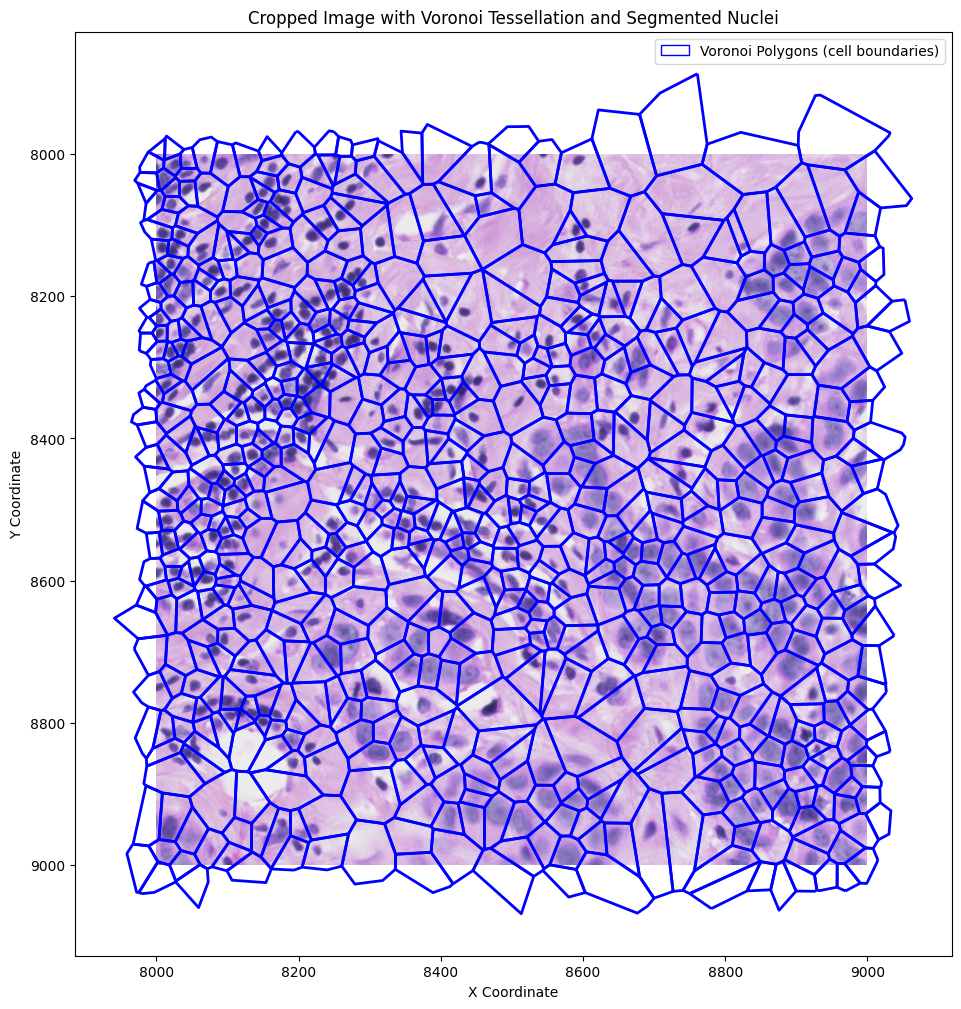

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from shapely.geometry import box

# Define bounding box
bbox = (8000, 8000, 9000, 9000)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Create a Polygon for the bounding box
bbox_polygon = box(*bbox)
vor_gdf.crs = None

# Filter both GeoDataFrames to only include polygons within the bounding box
gdf_bbox_filtered = vor_gdf[vor_gdf.intersects(bbox_polygon)]

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image with the original coordinate extent
ax.imshow(cropped_img, origin='upper', extent=[bbox[0], bbox[2], bbox[3], bbox[1]])

# Plot the Voronoi tessellation polygons from the filtered GeoDataFrame
gdf_bbox_filtered.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)

# Optionally, add a legend
legend_elements = [
    Patch(edgecolor='blue', facecolor='none', label='Voronoi Polygons (cell boundaries)'),
]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation and Segmented Nuclei')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


In [23]:
buffered_polygons = [polygon.buffer(-2.5) for polygon in polygons]


In [24]:
import geopandas as gpd
vor_gdf_buffered = gpd.GeoDataFrame(geometry=buffered_polygons)

Cropped image shape: (1000, 1000, 3)


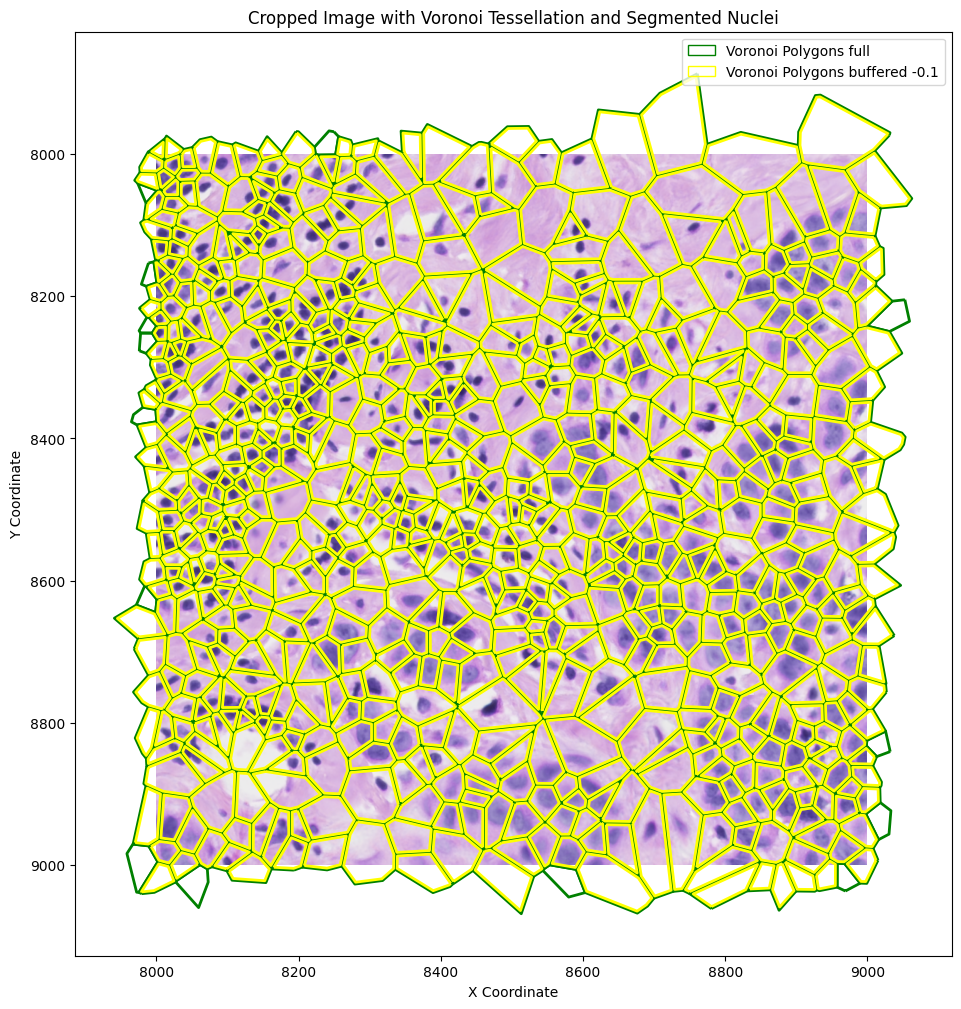

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.patches import Patch
from shapely.geometry import box

# Define bounding box
bbox = (8000, 8000, 9000, 9000)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Create a Polygon for the bounding box
bbox_polygon = box(*bbox)
vor_gdf.crs = None

# Filter both GeoDataFrames to only include polygons within the bounding box
gdf_bbox_filtered = vor_gdf[vor_gdf.intersects(bbox_polygon)]
gdf_bbox_filtered_buffered = vor_gdf_buffered[vor_gdf_buffered.intersects(bbox_polygon)]

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image with the original coordinate extent
ax.imshow(cropped_img, origin='upper', extent=[bbox[0], bbox[2], bbox[3], bbox[1]])

# Plot the Voronoi tessellation polygons from the filtered GeoDataFrame
gdf_bbox_filtered.plot(ax=ax, edgecolor='green', facecolor='none', linewidth=2)
gdf_bbox_filtered_buffered.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=2)

# Optionally, add a legend
legend_elements = [
    Patch(edgecolor='green', facecolor='none', label='Voronoi Polygons full'),
    Patch(edgecolor='yellow', facecolor='none', label='Voronoi Polygons buffered -0.1'),
]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation and Segmented Nuclei')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


In [26]:
vor_gdf_buffered.to_file('../data/xenium/voronoi_buffered.geojson', driver='GeoJSON')